In [169]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 
import scipy
from itertools import combinations 
pd.options.mode.chained_assignment = None  # default='warn'
from multiprocessing import Pool
from itertools import repeat
from itertools import compress
import json

MUSIC_CHOICES = ['classical music', 'pop', 'metal or hardrock', 'hiphop, rap', 'latino', 'alternative']

In [2]:
%cd ..

/Users/verajparuthi/Documents/music-prediction


In [3]:
raw_data = pd.read_csv('./resources/responses.csv')
raw_data.fillna(0, inplace=True)
raw_data.columns = [col.lower() for col in raw_data.columns]

In [4]:
def only_strong_correlations(x):
    if abs(x) < 0.1: return 0
    return x

def convert_to_binary(col):
    """
    Given a two value categorical series, it is converted to its binary representation
    
    :param Series col: two value categorical series
    
    :return: a binary series
    """
    
    unique_val = col.unique()[0]
    copy = col.copy()
    for index, row in enumerate(copy):
        if row == unique_val:
            copy[index] = 0
        else:
            copy[index] = 1
    return copy


In [5]:
# getting all the categorical columns 
categorical_data = raw_data[list(set(raw_data.columns) - set(raw_data._get_numeric_data().columns))]
categorical_data.drop(['gender'], axis=1, inplace=True)

In [6]:
# converting the binary categorical columns to 0s and 1s
# this is done to avoid linerly dependent columns 
binary_data = categorical_data[['left - right handed', 'only child']]
for col in binary_data:
    categorical_data.loc[:, col] = convert_to_binary(binary_data.loc[:, col])

In [7]:
# one hot encoding 
categorical_data = pd.get_dummies(categorical_data, prefix_sep='_', drop_first=True)

In [8]:
def generate_heatmap(df, music_choices=MUSIC_CHOICES, threshold=0.04, only_strong_corr=True):
    """
    Given a dataframe a heatmap is returned with only values above the 
    threhold being displayed
    
    :param DataFrame df: A numerical dataframe
    :param list music_choices: The genres of music that one would like displayed
    :param float threshold: The average value required for a row to be displayed
    
    :return: a sns heatmap
    """
    # corr is a square correlation matrix (n * n), where n is the number of featuress
    if only_strong_corr:
        # only_corrleations() makes cell values 0 if their correlation is less than 0.1
        df = df._get_numeric_data().corr().applymap(only_strong_correlations)
    else:
        df = df._get_numeric_data().corr()
        
    # picking only the music columns 
    df = df[music_choices]
    # excluding all music rows 
    df = df.loc[set(df.index) - set(music_choices)]

    # only rows above a certain threshold are kept
    # 0.04 was chosen as the threshold since it 
    # is slightly higher than the avg of the row avgs, which was 0.039

    # avg is the average of all the rows 
    avg = 0
    inital_len = len(df)
    for index, row in df.iterrows():
        add = 0
        for col in row: 
            add += abs(col)
        avg += add/len(row)
        if add/len(row) < threshold:
            df.drop(index, axis=0, inplace=True)
    print(avg/inital_len)
    
    plt.figure(figsize=(25,20))
    return sns.heatmap(df, cmap= sns.color_palette("RdBu_r", 7), annot=True, linewidth=0.5)


0.05432295617681911


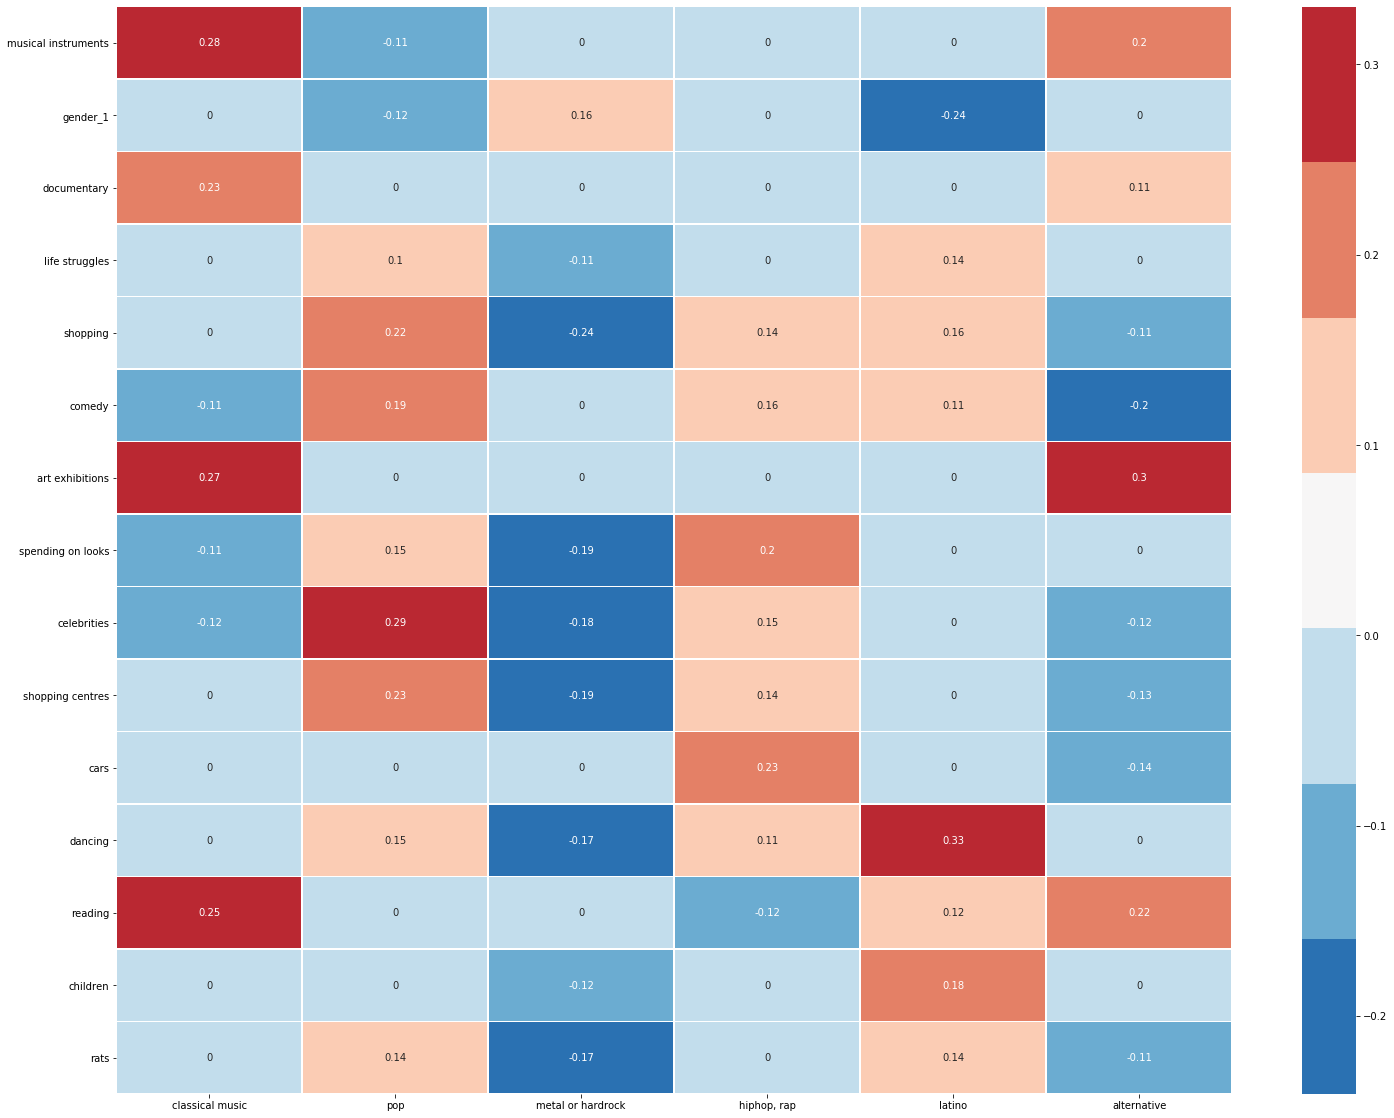

In [150]:
# generate_heatmap(question_data.join(music_data), only_strong_corr=True)

In [153]:
def create_music_labels(col):
    """
    Concludes an individual likes a genere of music if they rated it greater or equal to four.
    
    :param Series col: a series of integers 
    :return: a series of bools
    
    """
    return col.apply(lambda x: True if x >= 4 else False)
    

In [154]:
music_data = raw_data[MUSIC_CHOICES]
for col in music_data:
    music_data[col] = create_music_labels(music_data[col])

In [148]:
questions = []
for line in open('./resources/reduced_correlations.txt'):
    questions.append(line.lower().rstrip())
question_data = raw_data[questions]

# gender is binary so we convert that prior to OHE (One Hot Encoding)
question_data.loc[:,['gender']] = convert_to_binary(question_data['gender'])
# OHE
question_data = pd.get_dummies(question_data, drop_first=True).astype(int)

In [155]:
def create_model(question_data, music_data, grid_search, k=None, s=None):
    if grid_search:
        parameters = {'k': range(2,17,2), 's': [0.5, 0.7, 1.0]}
        score = 'f1_micro'   
        clf = GridSearchCV(MLkNN(), parameters, scoring=score, n_jobs=-1, cv=5)
        clf.fit(question_data.values, music_data.values)
        return clf.best_params_, clf.best_score_
    else:
        clf = MLkNN(k=k, s=s)
        clf.fit(question_data.values, music_data.values)
        return clf

In [183]:

# distribution of choices of music people like
d = {}
for row in music_data.values.tolist():
    row = tuple(row)
    if row in d.keys():
        d[row] += 1
    else:
        d[row] = 1
highest_counts = sorted(d.values(), reverse=True)[:6]

for category, value in d.items():
    if value in highest_counts:
        print(list(compress(list(music_data.columns), list(category))), value)

['pop'] 82
['pop', 'latino'] 51
['hiphop, rap'] 58
['pop', 'hiphop, rap'] 92
[] 59
['pop', 'hiphop, rap', 'latino'] 62


In [ ]:
def find_best_features(question_data, music_data):
    """
    Finds the best ten features to use for a given dataset.
    Utilizes GridSearchCV to figure out the best hyperparamter values. 
    
    """
    
    best_score = 0
    best_params = None
    best_comb = None

    X_train, X_test, y_train, y_test = train_test_split(question_data, music_data, test_size=0.05, random_state=42)

    feature_set = set(X_train.columns)
    feature_set.remove('gender_1')

    for index, comb in enumerate(list(combinations(feature_set, 9))):
        comb = list(comb + ('gender_1',))
        params, score = create_model(X_train[comb], y_train, True)
        if score > best_score:
            best_score = score
            best_params = params
            best_comb = comb
        print(index)
    return best_score, best_params, best_comb

In [186]:
# creating the actual model to be used
with open('./resources/final_model_values.json') as file:
    json_file = json.load(file)
features = json_file['features']
clf = create_model(question_data[features], music_data, False, 4, 0.5)

In [187]:
from random import choices
d = {}
for i in range(10000):
    a = choices(range(0, 5), k=9)
    a.append(0)
    a = clf.predict(np.asarray([a]))
    a = a.todense()
    for index in range(6):
        if a[0,index] == 1:
            if index in d.keys():
                d[index] +=1
            else:
                d[index] = 1
print(d)

{0: 4324, 2: 3699, 5: 5964, 3: 1883, 1: 1617, 4: 349}


In [204]:
response = np.asarray([[2,2,4,1,3,5,0,4,4,1]])

genres = list(compress(list(music_data.columns), clf.predict(response).toarray()[0]))
proba = clf.predict_proba(response).toarray()[0]
print(genres, proba)


['hiphop, rap'] [0.08210206 0.07144285 0.07406263 0.15891192 0.08896531 0.00049152]
